In [1]:
import pandas as pd

df = pd.read_csv('./data/usd_aud.csv', parse_dates=True)
df['Date'] =  pd.to_datetime(df['Date'], format='%b %d, %Y')
df.head()

,Date,Price,Open,High,Low,Change_%
0,2018-07-06,1.3453,1.3539,1.3560,1.3433,-0.62%
1,2018-07-05,1.3537,1.3541,1.3585,1.3495,-0.06%
2,2018-07-04,1.3545,1.3545,1.3563,1.3469,0.04%
3,2018-07-03,1.3539,1.3624,1.3673,1.3503,-0.60%
4,2018-07-02,1.3621,1.3509,1.3680,1.3483,0.76%


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 6 columns):
Date        5223 non-null datetime64[ns]
Price       5223 non-null float64
Open        5223 non-null float64
High        5223 non-null float64
Low         5223 non-null float64
Change_%    5223 non-null object
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 244.9+ KB


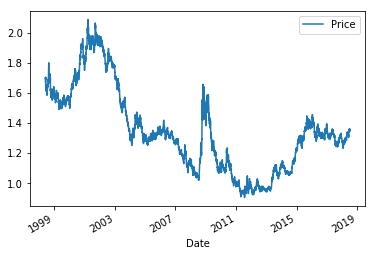

In [3]:
%matplotlib inline
df.plot('Date', 'Price')

In [4]:
df.sort_values('Date', ascending=True, inplace=True)
df.head()

,Date,Price,Open,High,Low,Change_%
5222,1998-06-08,1.6711,1.6714,1.6711,1.6714,0.44%
5221,1998-06-09,1.6820,1.6736,1.6820,1.6736,0.65%
5220,1998-06-10,1.7030,1.7024,1.7030,1.7024,1.25%
5219,1998-06-11,1.7010,1.6935,1.7010,1.6935,-0.12%
5218,1998-06-12,1.6904,1.6838,1.6904,1.6838,-0.62%


In [5]:
from sklearn.preprocessing import StandardScaler

closing = df['Price'].values

scaler = StandardScaler()
closing_scaled = scaler.fit_transform(closing.reshape(-1, 1))

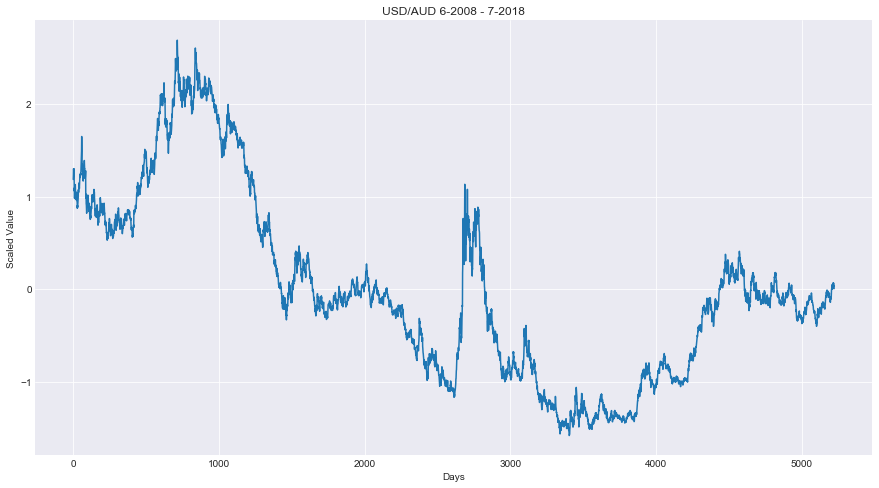

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

sns.set_style("darkgrid")
plt.figure(figsize=(15,8))
plt.title('USD/AUD 6-2008 - 7-2018')
plt.xlabel('Days')
plt.ylabel('Scaled Value')
plt.plot(closing_scaled)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(closing_scaled, test_size=0.25, shuffle=False)
print(train.shape)
print(test.shape)

(3917, 1)
(1306, 1)


In [8]:
import tensorflow as tf

n_epochs= 100
batch_size = 1
time_step = 1
n_neurons = 25
learning_rate = 0.001

def chunk_data(data, step_size):
    x = [data[i:i+step_size] for i in range(len(data) - step_size - 1)]
    y = [data[i+step_size][0] for i in range(len(data) - step_size - 1)]
    x = np.array(x)
    y = np.array(y)
    x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
    return x, y

X_train, y_train = chunk_data(train, time_step)
X_test, y_test = chunk_data(test, time_step)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3915, 1, 1) (3915,)
(1304, 1, 1) (1304,)


In [9]:
X = tf.placeholder(tf.float32, shape=[None, batch_size, time_step])
y = tf.placeholder(tf.float32, shape=[None])

lstm_cell = tf.contrib.rnn.LSTMCell(n_neurons)
outputs, states = tf.nn.dynamic_rnn(lstm_cell, X, dtype=tf.float32)
logits = tf.layers.dense(outputs[-1], 1, activation=None, name='softmax')
loss = tf.reduce_mean(tf.squared_difference(logits, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [10]:
for epoch in range(n_epochs):
    for i in range(len(X_train)):
        X_batch = X_train[i:i + batch_size, :, :]
        y_batch = y_train[i:i+batch_size]
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    train_loss = sess.run(loss, feed_dict={X: X_batch, y: y_batch})
    print(f"Epoch: {epoch}, current loss: {train_loss}")

Epoch: 0, current loss: 9.97579627437517e-05
Epoch: 1, current loss: 0.00020386793767102063
Epoch: 2, current loss: 0.00020069068705197424
Epoch: 3, current loss: 0.000206362281460315
Epoch: 4, current loss: 0.0001972704048966989
Epoch: 5, current loss: 0.00020068224694114178
Epoch: 6, current loss: 0.00018787482986226678
Epoch: 7, current loss: 0.00017544545698910952
Epoch: 8, current loss: 0.0001726116461213678
Epoch: 9, current loss: 0.00017078717064578086
Epoch: 10, current loss: 0.0001701723667792976
Epoch: 11, current loss: 0.00015828282630536705
Epoch: 12, current loss: 0.00015096501738298684
Epoch: 13, current loss: 0.00015104119665920734
Epoch: 14, current loss: 0.00015125516802072525
Epoch: 15, current loss: 0.0001460693310946226
Epoch: 16, current loss: 0.00014181737788021564
Epoch: 17, current loss: 0.00013678203686140478
Epoch: 18, current loss: 0.00013271653733681887
Epoch: 19, current loss: 0.00013614562340080738
Epoch: 20, current loss: 0.0001312047243118286
Epoch: 21, 

In [11]:
y_test_res = np.zeros(y_test.shape[0], dtype=np.float32)
for i in range(len(y_test)):
    X_batch = X_test[i:i + batch_size, :, :]
    y_test_res[i:i + batch_size] = sess.run(logits, feed_dict={X:X_batch})

In [12]:
import math
from sklearn.metrics import mean_squared_error

y_test_reg = scaler.inverse_transform([y_test])
y_pred = scaler.inverse_transform([y_test_res])
training_set = closing[:X_train.shape[0]]
print(f'Test RMSE: {round(math.sqrt(mean_squared_error(y_test_reg, y_pred)), 4)}')

Test RMSE: 0.0186


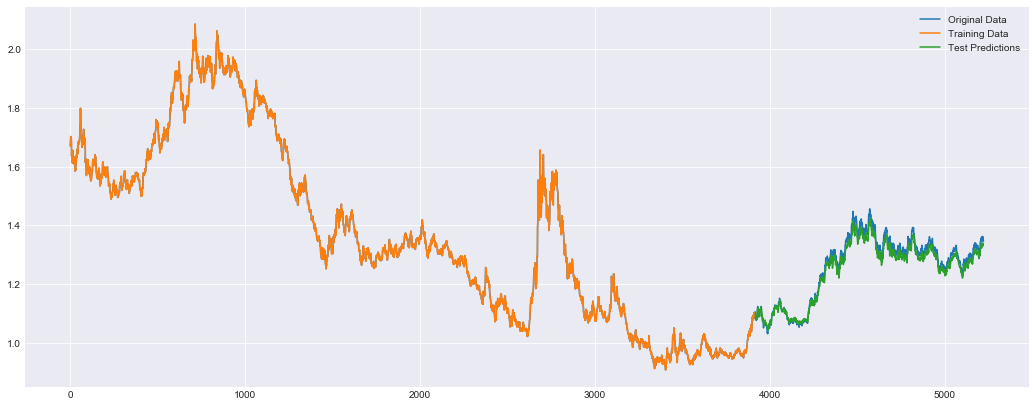

In [13]:
plt.figure(figsize=(18,7))
plt.plot(closing, label='Original Data')
plt.plot(training_set, label='Training Data')
x = np.array(range(len(training_set)+(time_step*2)+1,len(closing_scaled)-1))
plt.plot(x, y_pred.T, label='Test Predictions')
plt.legend()
plt.show()

In [14]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

output_notebook()

p = figure(title='LSTM Results', plot_height=450, plot_width=950)
p.line([x for x in range(len(closing))], closing,  line_width=2, color='blue', legend='Original Data')
p.line([x for x in range(len(training_set))],training_set, line_width=2, color='orange', legend='Training Data')
p.line(x, y_pred.T.squeeze(), line_width=2, color='green', legend='Test Predictions')
p.legend.location = "top_right"
show(p)

Loading BokehJS ...